## IMPORTS/DRIVE

In [2]:
pip install linearmodels


In [3]:
# Manipulação dos dados
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Econometria
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import statsmodels.stats.diagnostic as smd
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy.stats as scs

from linearmodels import PanelOLS
from linearmodels import PooledOLS
from linearmodels import RandomEffects


In [4]:
# Conecta o notebook ao Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## EDA

In [5]:
# Carrega os dados do Brasil
#sheet_name=0 - SEM INDETERMINADO
br = pd.read_excel('/content/drive/MyDrive/Pesquisa - Talles/Padrões de normas vigentes no comércio internacional: caracterização e análise do efeito da norma Globalgap sobre as exportações de frutas no Brasil, Chile e Argentina./Dados/BASE_BRASIL.xlsx',
                   sheet_name=0)


In [6]:
br.head()

,ano,estado,regiao,fruta,exp_kg,exp_fob,exp_USD/KG,empresas_gg,area_plantada(ha),area_colhida(ha),qte_produzida(ton),rendimento_medio_producao(kg/ha),valor_producao(mil reais),rendimento_medio_producao(R$/Kg),renda_internacional,renda_int_bilh
0,2018,alagoas,Nordeste,abacate,5,14,2.800000,NaN,101,101,980,9703,1809,1.845918,2.120494e+11,212.049447
1,2018,alagoas,Nordeste,limao_e_lima,63,140,2.222222,NaN,322,322,1909,5929,3594,1.882661,2.120494e+11,212.049447
2,2018,alagoas,Nordeste,maca,766,2071,2.703655,NaN,0,0,0,0,0,0.000000,3.251213e+11,325.121254
3,2018,alagoas,Nordeste,manga,345,477,1.382609,NaN,1301,1301,11201,8610,8275,0.738773,9.981976e+11,998.197567
4,2018,alagoas,Nordeste,melancia,384,186,0.484375,NaN,960,960,17919,18666,14992,0.836654,2.120494e+11,212.049447


In [7]:
# Preenche os certiicados faltantes com zeros
br['empresas_gg'].fillna(0, inplace=True)

# Converte os valores das empresas de float para int
br['empresas_gg'] = br['empresas_gg'].astype(int)

# Renomeção de colunas
br.rename(columns={'exp_USD/KG': 'preco', 'qte_produzida(ton)': 'producao', 'renda_int_bilh': 'renda'}, inplace=True)


<ipython-input-7-ccbaefa78f83>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  br['empresas_gg'].fillna(0, inplace=True)


In [8]:
# Padronizar valores e unidades das variáveis
# Tonelada para quilograma -> Produção
br['producao'] = br['producao'] * 1000
br['valor_producao(mil reais)'] = br['valor_producao(mil reais)'] * 1000

In [9]:
################################################################################
br.describe()
################################################################################

,ano,exp_kg,exp_fob,preco,empresas_gg,area_plantada(ha),area_colhida(ha),producao,rendimento_medio_producao(kg/ha),valor_producao(mil reais),rendimento_medio_producao(R$/Kg),renda_internacional,renda
count,693.000000,6.930000e+02,6.930000e+02,693.000000,693.000000,693.000000,693.000000,6.930000e+02,693.000000,6.930000e+02,693.000000,6.930000e+02,693.000000
mean,2020.056277,6.170503e+06,5.457896e+06,1.437002,3.002886,2741.914863,2724.295815,6.815312e+07,15254.170274,9.176114e+07,1.326343,1.262545e+12,1262.544905
std,1.389892,2.136184e+07,1.798343e+07,1.066714,13.022768,6219.549235,6195.710756,1.611866e+08,12933.154542,2.319472e+08,1.207057,1.551205e+12,1551.204767
min,2018.000000,5.000000e+00,5.000000e+00,0.025763,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,4.787637e+09,4.787637
25%,2019.000000,3.443000e+03,4.742000e+03,0.726556,0.000000,8.000000,8.000000,8.600000e+04,5036.000000,1.070000e+05,0.578718,3.404265e+11,340.426515
50%,2020.000000,3.493600e+04,3.790300e+04,1.156366,0.000000,342.000000,342.000000,4.495000e+06,14511.000000,7.481000e+06,1.144048,9.140434e+11,914.043438
75%,2021.000000,9.349320e+05,6.196810e+05,1.831000,0.000000,2067.000000,2052.000000,5.006100e+07,22546.000000,6.327700e+07,1.856663,1.622587e+12,1622.587263
max,2022.000000,1.867893e+08,1.231581e+08,7.131367,146.000000,46858.000000,46857.000000,1.199368e+09,73806.000000,1.712957e+09,7.436620,1.428772e+13,14287.715380


In [10]:
# Logaritmização das variáveis
# Transforma os valores em logaritmos neperianos

# Dados da BASE BRASIL
br['exp_fob'] = np.log(br['exp_fob'])
br['preco'] = np.log(br['preco'])
br['producao'] = np.log(br['producao'])
br['renda'] = np.log(br['renda'])
br['renda_internacional'] = np.log(br['renda_internacional'])

#br['exp_kg'] = np.log(br['exp_kg'])

#br['area_colhida(ha)'] = np.log(br['area_colhida(ha)'])
#br['area_plantada(ha)'] = np.log(br['area_plantada(ha)'])
#br['rendimento_medio_producao(R$/Kg)'] = np.log(br['rendimento_medio_producao(R$/Kg)'])
#br['rendimento_medio_producao(kg/ha)'] = np.log(br['rendimento_medio_producao(kg/ha)'])
#br['valor_producao(mil reais)'] = np.log(br['valor_producao(mil reais)'])

# Substitui valores: -inf
br = br.replace(-np.inf, 0)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
################################################################################
br.describe()
################################################################################

,ano,exp_kg,exp_fob,preco,empresas_gg,area_plantada(ha),area_colhida(ha),producao,rendimento_medio_producao(kg/ha),valor_producao(mil reais),rendimento_medio_producao(R$/Kg),renda_internacional,renda
count,693.000000,6.930000e+02,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,6.930000e+02,693.000000,693.000000,693.000000
mean,2020.056277,6.170503e+06,11.037661,0.087970,3.002886,2741.914863,2724.295815,12.656526,15254.170274,9.176114e+07,1.326343,27.151012,6.427746
std,1.389892,2.136184e+07,3.481909,0.825932,13.022768,6219.549235,6195.710756,7.021691,12933.154542,2.319472e+08,1.207057,1.480334,1.480334
min,2018.000000,5.000000e+00,1.609438,-3.658833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,22.289303,1.566037
25%,2019.000000,3.443000e+03,8.464214,-0.319440,0.000000,8.000000,8.000000,11.362103,5036.000000,1.070000e+05,0.578718,26.553465,5.830199
50%,2020.000000,3.493600e+04,10.542786,0.145282,0.000000,342.000000,342.000000,15.318476,14511.000000,7.481000e+06,1.144048,27.541144,6.817878
75%,2021.000000,9.349320e+05,13.336960,0.604862,0.000000,2067.000000,2052.000000,17.728753,22546.000000,6.327700e+07,1.856663,28.115043,7.391777
max,2022.000000,1.867893e+08,18.628979,1.964503,146.000000,46858.000000,46857.000000,20.905061,73806.000000,1.712957e+09,7.436620,30.290421,9.567155


---

TESTE SEM OS -INF

In [12]:
# Substitui os valores -inf por NaN
br.replace(-np.inf, np.nan, inplace=True)

# Excluí as 149 obs com NULOS / Produção = 0 / -inf
br.dropna(inplace=True)


In [13]:
br.shape

(693, 16)

---

<Axes: xlabel='empresas_gg', ylabel='exp_fob'>

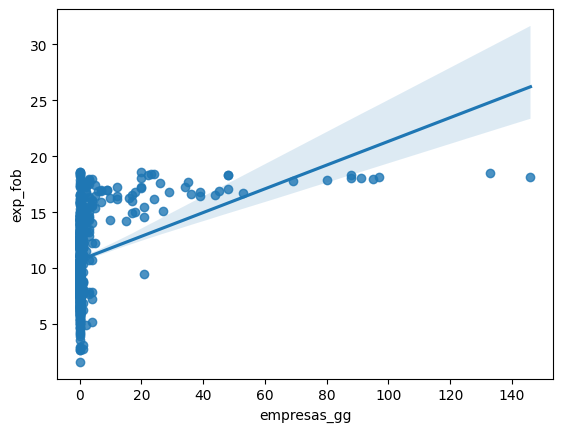

In [14]:
sns.regplot(data=br, x='empresas_gg', y='exp_fob')

<Axes: xlabel='empresas_gg', ylabel='estado'>

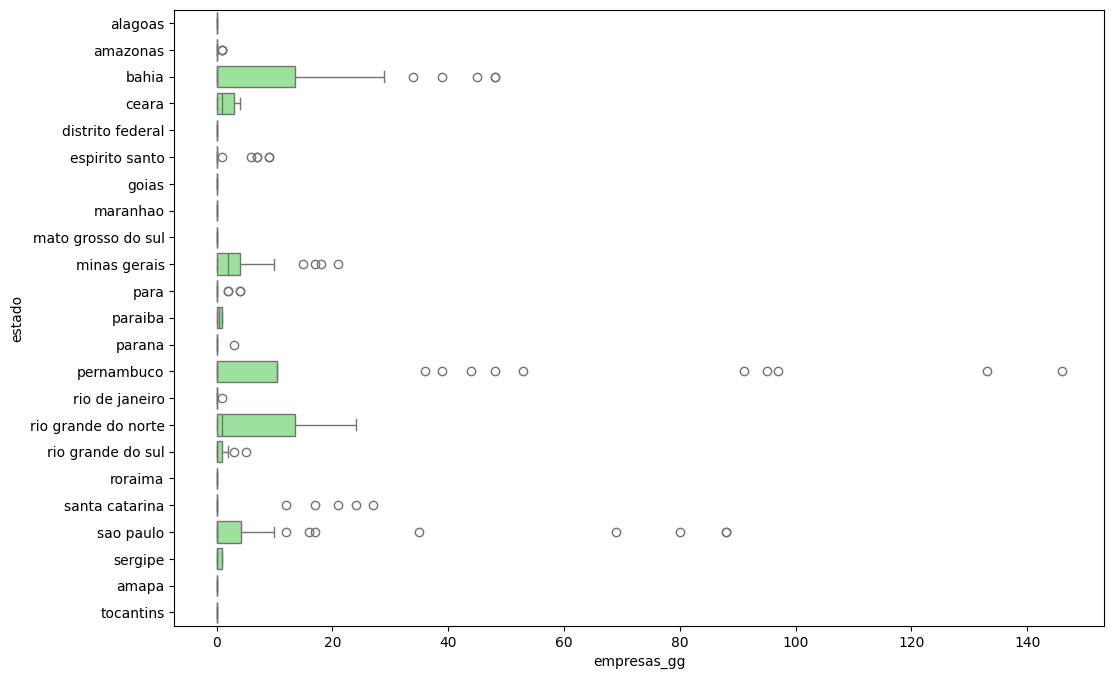

In [15]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=br, x='empresas_gg', y="estado", color='lightgreen')


---

## PAINEL - EFEITOS FIXOS

In [16]:
br1 = pd.get_dummies(br, columns=['fruta'], drop_first=True)
#br1 = br.copy()

In [17]:
# Converte os dados das dummies de boolean para int
bool_columns = br1.select_dtypes(include=['bool']).columns
br1[bool_columns] = br1[bool_columns].astype(int)


In [18]:
# Define o Índice
base_painel = br1.set_index(['estado', 'ano'])


In [19]:
# Criação das variáveis
Y = base_painel['exp_fob']
X = base_painel.drop(columns=['exp_fob', 'regiao', 'renda_internacional', 'area_plantada(ha)',
                              'area_colhida(ha)', 'rendimento_medio_producao(kg/ha)',
                              'valor_producao(mil reais)', 'rendimento_medio_producao(R$/Kg)',
                              'exp_kg'], axis=1)

# Adiciona a constante ao modelo
X = sm.add_constant(X)


In [20]:
# EFEITOS FIXOS!
mrl = PanelOLS(Y, X, entity_effects=True, time_effects=True)
modelo = mrl.fit(cov_type='robust') # Usa estimador robusto de MQO
print(modelo.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                exp_fob   R-squared:                        0.3279
Estimator:                   PanelOLS   R-squared (Between):              0.5864
No. Observations:                 693   R-squared (Within):               0.3242
Date:                Sun, Dec 15 2024   R-squared (Overall):              0.4489
Time:                        13:13:42   Log-likelihood                   -1471.4
Cov. Estimator:                Robust                                           
                                        F-statistic:                      29.046
Entities:                          23   P-value                           0.0000
Avg Obs:                       30.130   Distribution:                  F(11,655)
Min Obs:                       1.0000                                           
Max Obs:                       40.000   F-statistic (robust):             26.138
                            

In [21]:
mre = RandomEffects(Y, X)
modelo = mre.fit(cov_type='robust')
print(modelo.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                exp_fob   R-squared:                        0.3948
Estimator:              RandomEffects   R-squared (Between):              0.6755
No. Observations:                 693   R-squared (Within):               0.3167
Date:                Sun, Dec 15 2024   R-squared (Overall):              0.4841
Time:                        13:13:42   Log-likelihood                   -1526.7
Cov. Estimator:                Robust                                           
                                        F-statistic:                      40.394
Entities:                          23   P-value                           0.0000
Avg Obs:                       30.130   Distribution:                  F(11,681)
Min Obs:                       1.0000                                           
Max Obs:                       40.000   F-statistic (robust):             39.029
                            

---

## HETEROCEDASTICIDADE

**Heterocedasticidade - PAINEL FE**

In [22]:
# Executa o teste de White para o modelo de painel
# Retorna os coeficientes do Multiplicador de Lagrange e seu p-valor
residuals = modelo.resids
white_test = smd.het_white(resid=residuals, exog=X)
print('lm:', white_test[0], '\nlm_pvalue:', white_test[1])


lm: 86.22160126190984 
lm_pvalue: 0.0005901498697792807


---

## OUTROS TESTES

**Multicolinearidade**

In [23]:
# FIV - FATOR DE INFLAÇÃO DA VARIÂNCIA
# Define função para o cálculo do FIV
def calculate_fiv(dataset):
  vif = pd.DataFrame()
  vif['features'] = dataset.columns
  vif['VIF_Value'] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]

  return vif


In [24]:
# Cálculo dos FIV's
features = X.drop(columns='const', axis=1) # Variáveis para o cálculo do FIV
calculate_fiv(features)


,features,VIF_Value
0,preco,2.473622
1,empresas_gg,1.186165
2,producao,6.922902
3,renda,11.496430
4,fruta_limao_e_lima,1.913289
5,fruta_maca,1.642024
6,fruta_mamao,1.890956
7,fruta_manga,2.001110
8,fruta_melancia,2.734633
9,fruta_melao,1.802442


In [25]:
# Cria dataset novo para cálculo da matriz de correlação
br2 = br.drop(columns=['ano', 'estado', 'regiao', 'fruta', 'renda_internacional'], axis=1)

In [26]:
# Análise da matriz de correlação
# A variação com a maior correlação com a variável "target" é a mais "útil" de se manter
# Considerando variáveis com VIF_Value alto
br2.corr()


,exp_kg,exp_fob,preco,empresas_gg,area_plantada(ha),area_colhida(ha),producao,rendimento_medio_producao(kg/ha),valor_producao(mil reais),rendimento_medio_producao(R$/Kg),renda
exp_kg,1.000000,0.544064,-0.104247,0.398818,0.537513,0.537333,0.275608,0.292370,0.508976,-0.014416,0.250983
exp_fob,0.544064,1.000000,-0.181446,0.397143,0.439206,0.438205,0.483346,0.481868,0.489266,0.110866,0.513796
preco,-0.104247,-0.181446,1.000000,0.025735,-0.132055,-0.131226,-0.420342,-0.360064,-0.025927,0.102250,0.106203
empresas_gg,0.398818,0.397143,0.025735,1.000000,0.358566,0.355664,0.211542,0.286710,0.644759,0.146226,0.209270
area_plantada(ha),0.537513,0.439206,-0.132055,0.358566,1.000000,0.999922,0.416066,0.333408,0.812740,0.009315,0.158446
area_colhida(ha),0.537333,0.438205,-0.131226,0.355664,0.999922,1.000000,0.415100,0.332413,0.811590,0.008971,0.157248
producao,0.275608,0.483346,-0.420342,0.211542,0.416066,0.415100,1.000000,0.731344,0.381763,0.472526,0.266043
rendimento_medio_producao(kg/ha),0.292370,0.481868,-0.360064,0.286710,0.333408,0.332413,0.731344,1.000000,0.454974,0.271780,0.230269
valor_producao(mil reais),0.508976,0.489266,-0.025927,0.644759,0.812740,0.811590,0.381763,0.454974,1.000000,0.163805,0.219350
rendimento_medio_producao(R$/Kg),-0.014416,0.110866,0.102250,0.146226,0.009315,0.008971,0.472526,0.271780,0.163805,1.000000,0.082985


---